In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, show
from astropy.io import fits

In [2]:
IDs_34 = [772,804,1109,1167,1961,8803,16125,22266,22812,26566,26788,27145,30578,31479,31873,49372,70173,71890,79534]
IDs_56 = [113,761,903,3012,6189,14285,24707,44699,47918,53927,54834,62309,79349,80185,81497,83030]

z_34 = [3.8531,3.6645,3.9183,3.6673,3.6418,3.208,3.3659,3.1371,3.0736,3.1336,3.8499,3.2001,3.1317,3.2072,3.2334,3.2435,3.0043,3.4183,3.2167]
z_56 = [5.788,5.546,5.7762,5.277,5.1834,5.4415,5.9383,5.0355,5.7774,5.8725,5.778,5.1747,5.1794,5.4926,5.3967,5.1236]

In [3]:
#function to open fits files
def open_fits(ID):
    filename = f"FITS/{ID}.fits"
    with fits.open(filename) as hdul:
        data = hdul[1].data 
        wavelength = data.wave
        flux = data.flux
        error = data.err
    return wavelength, flux, error

## (ii)

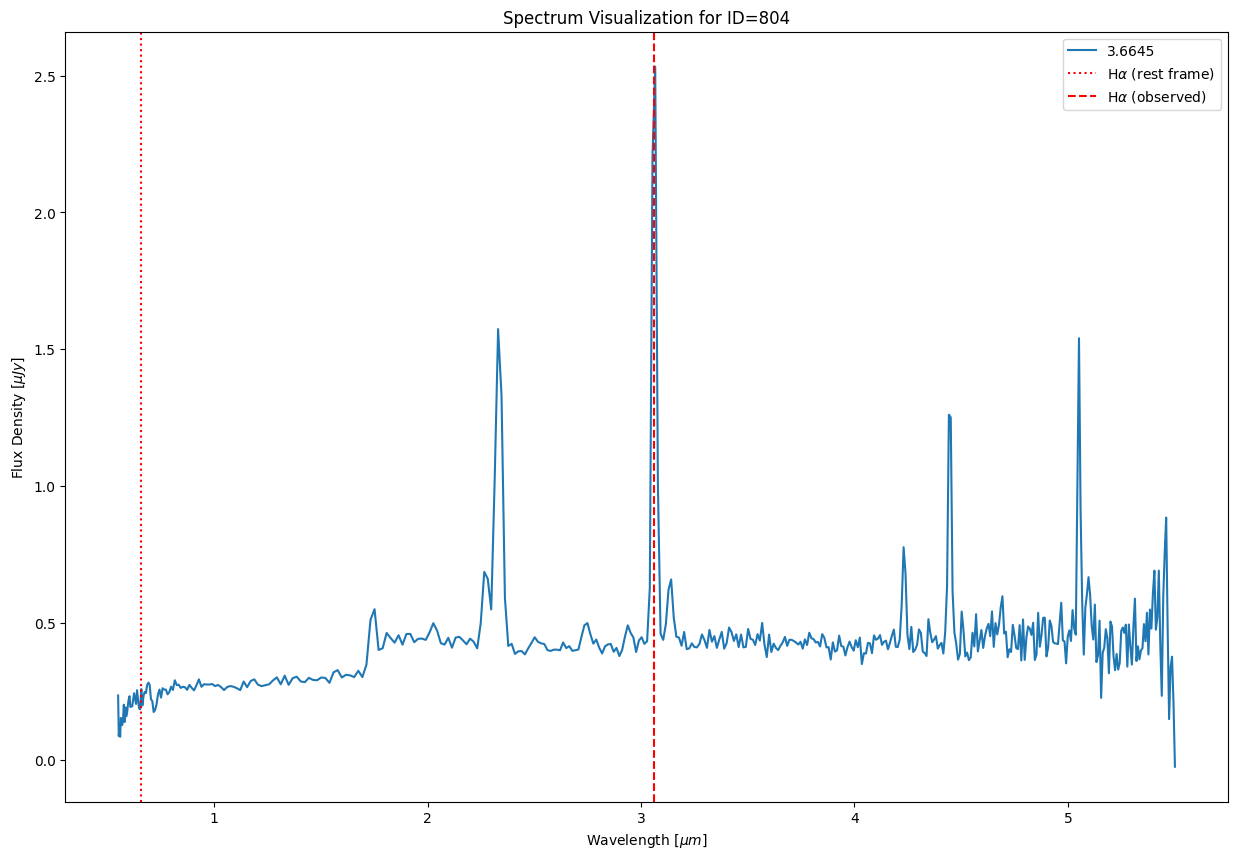

In [22]:
fig = figure(figsize=(15,10))
frame = fig.add_subplot()

#create dictionaries for easier look-up
id_to_z = dict(zip(IDs_34, z_34))
id_to_z.update(dict(zip(IDs_56, z_56)))

#one visualization
ID = 804
z_value = id_to_z.get(ID, None)
Ha = 6563

#open fits file
wave, flux, error = open_fits(ID)

frame.plot(wave, flux, label=z_value)

frame.set_ylabel(r'Flux Density [$\mu Jy$]')
frame.set_xlabel(r'Wavelength [$\mu m$]')
frame.axvline(Ha*1e-4,c='red',linestyle=':',label=r'H$\alpha$ (rest frame)')

#redshifted
frame.axvline((Ha*1e-4*z_value + Ha*1e-4),c='red',linestyle='--',label=r'H$\alpha$ (observed)') 
frame.set_title(f'Spectrum Visualization for ID={ID}')
frame.legend()
show()

## (iii)

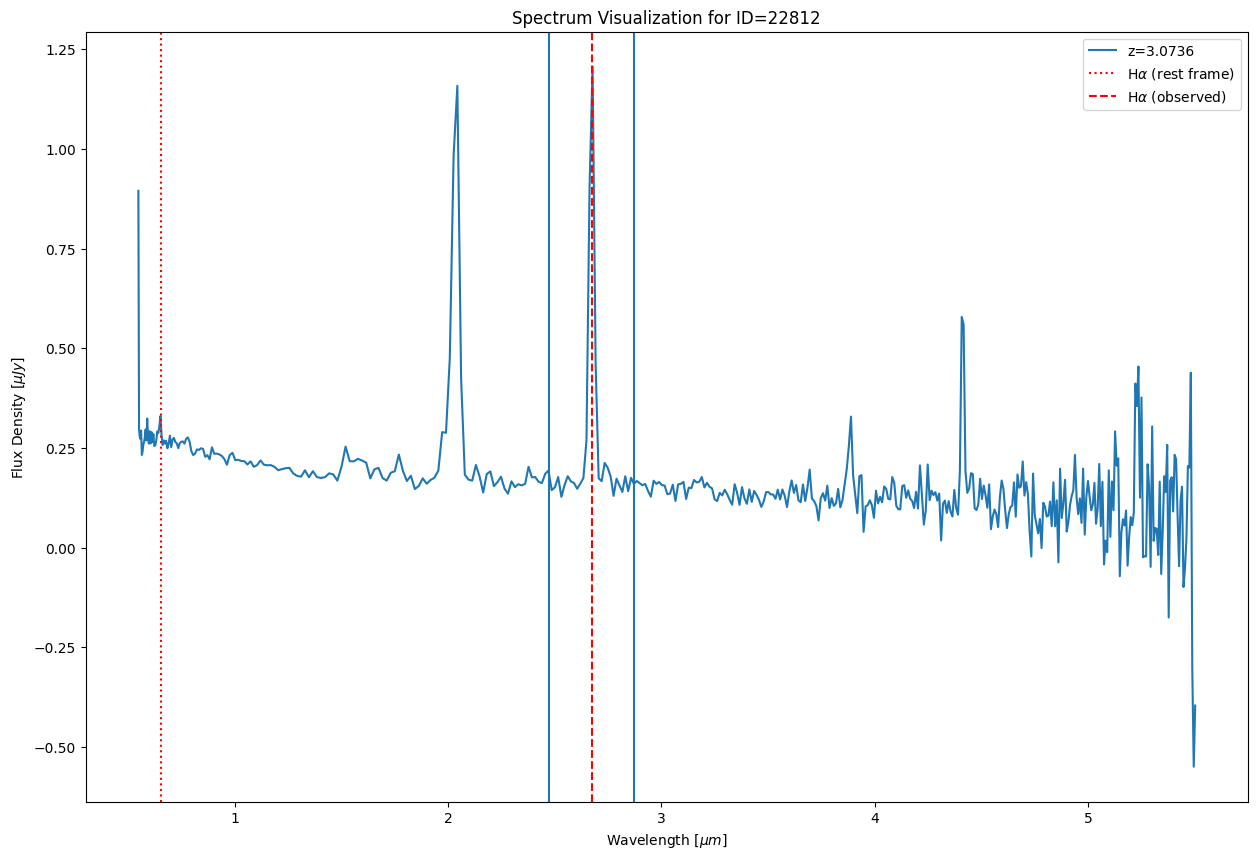

In [30]:
fig = figure(figsize=(15,10))
frame = fig.add_subplot()
#one visualization
ID = 22812
z_value = id_to_z.get(ID, None)
Ha = 6563

#open fits file
wave, flux, error = open_fits(ID)

frame.plot(wave, flux, label=f'z={z_value}')

frame.set_ylabel(r'Flux Density [$\mu Jy$]')
frame.set_xlabel(r'Wavelength [$\mu m$]')
frame.axvline(Ha*1e-4,c='red',linestyle=':',label=r'H$\alpha$ (rest frame)')

#redshifted
frame.axvline((Ha*1e-4*z_value + Ha*1e-4),c='red',linestyle='--',label=r'H$\alpha$ (observed)') 
frame.set_title(f'Spectrum Visualization for ID={ID}')
frame.legend()

frame.axvline(Ha*1e-4*z_value + Ha*1e-4 - .2)
frame.axvline(Ha*1e-4*z_value + Ha*1e-4 + .2)

show()

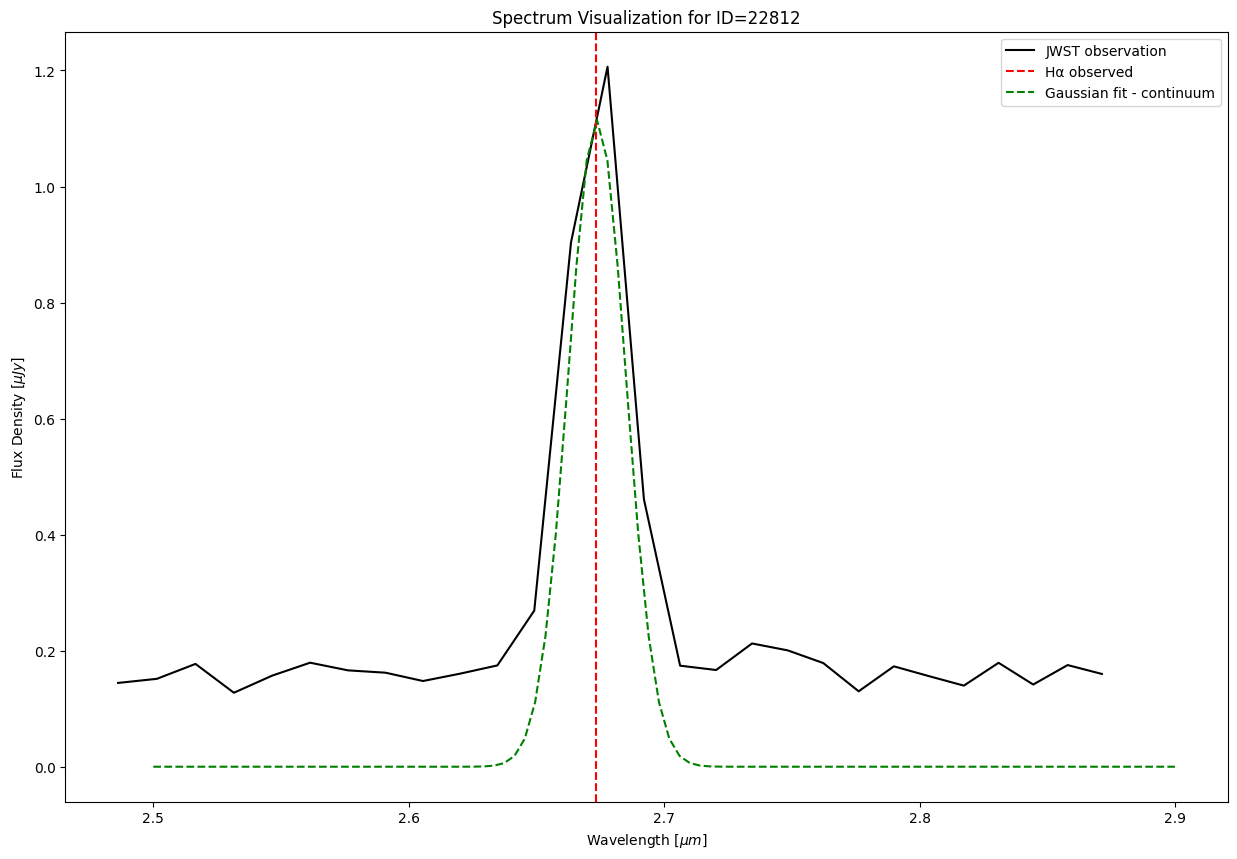

Area of the Gaussian, i.e. Ha flux: 0.0315


In [67]:
import scipy.stats as scs
from scipy.optimize import curve_fit

# Example values
ID = 22812
z_value = id_to_z.get(ID, None)
Ha = 6563  # rest-frame Hα in Å
wave, flux, error = open_fits(ID)

# Observed 
Ha_obs = Ha*1e-4*(1+z_value)  # in µm

# sliced window
delta = 0.2  # µm
mask = (wave >= Ha_obs - delta) & (wave <= Ha_obs + delta)

wave_slice = wave[mask]
flux_slice = flux[mask]

# Plot full spectrum
fig = figure(figsize=(15,10))
frame = fig.add_subplot()

frame.plot(wave_slice, flux_slice, color='black',label='JWST observation')

frame.set_xlabel(r'Wavelength [$\mu m$]')
frame.set_ylabel(r'Flux Density [$\mu Jy$]')

#frame.axvline(Ha*1e-4, c='red', linestyle=':', label='Hα rest')
frame.axvline(Ha_obs, c='red', linestyle='--', label='Hα observed')
frame.set_title(f'Spectrum Visualization for ID={ID}')

# C accounts for the continuum
def gaussian(x, A, mu, sigma, C):
    return A * np.exp(-(x - mu)**2 / (2*sigma**2)) + C

params, cov = curve_fit(gaussian, wave_slice, flux_slice, p0=[1.2,Ha_obs,0.05,flux_slice.min()])

#fitting parameters
A_fit, mu_fit, sigma_fit, continuum = params

#plot fit and subtract the continuum
plt.plot(np.linspace(2.5,2.9,100), gaussian(np.linspace(2.5,2.9,100), A_fit, mu_fit, sigma_fit, continuum)-continuum, 'g--', label='Gaussian fit - continuum')
frame.legend()

area = A_fit * abs(sigma_fit) * np.sqrt(2*np.pi) #micro Jy * micro m

show()

print(fr"Area of the Gaussian, i.e. Ha flux: {area:.4f}")

In [65]:
#example for the above ID
from astropy.cosmology import Planck18 as cosmo

#convert lineflux to cgs
F_Ha_cgs = (area * 10e-33 * 3e10) / ((Ha_obs *1e-4)**2) #erg s-1 cm-2


#luminosity distance
z = z_value
dL = cosmo.luminosity_distance(z)
dL_cm = dL.to('cm')

#H_alpha luminosity
L_H = 4*np.pi*dL_cm.value**2 * F_Ha_cgs

In [66]:
L_H #erg s-1

1.1364445959522656e+43

## (iv) H_alpha luminosity for all objects